In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

In [43]:
# === Load Data ===
df_raw = pd.read_csv('Assignment4_2025_data.csv', skiprows=2)
print(df_raw.columns)  # See the actual column names in the CSV
print(len(df_raw.columns))  # Count the columns

# === [Load and Prepare Data] ===
df_raw = pd.read_csv('Assignment4_2025_data.csv', skiprows=2)
df_raw.columns = ['Date', 'SOFR','DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2','DGS3','DGS5','DGS7','DGS10','DGS20','DGS30']
df_raw['Date'] = pd.to_datetime('1899-12-28') + pd.to_timedelta(df_raw['Date'], unit='D')  # Excel origin fix
df_raw.set_index('Date', inplace=True)
df_raw.sort_index(inplace=True)
data = df_raw.copy()
symbol_list = ['SOFR','DGS1MO','DGS3MO','DGS6MO','DGS1','DGS2','DGS3','DGS5','DGS7','DGS10','DGS20','DGS30']
data = df_raw.dropna()
columns = data.columns.tolist()

Index(['43194', '1.74', '1.67', '1.71', '1.9', '2.07', '2.28', '2.42', '2.61',
       '2.73', '2.79', '2.91', '3.03'],
      dtype='object')
13


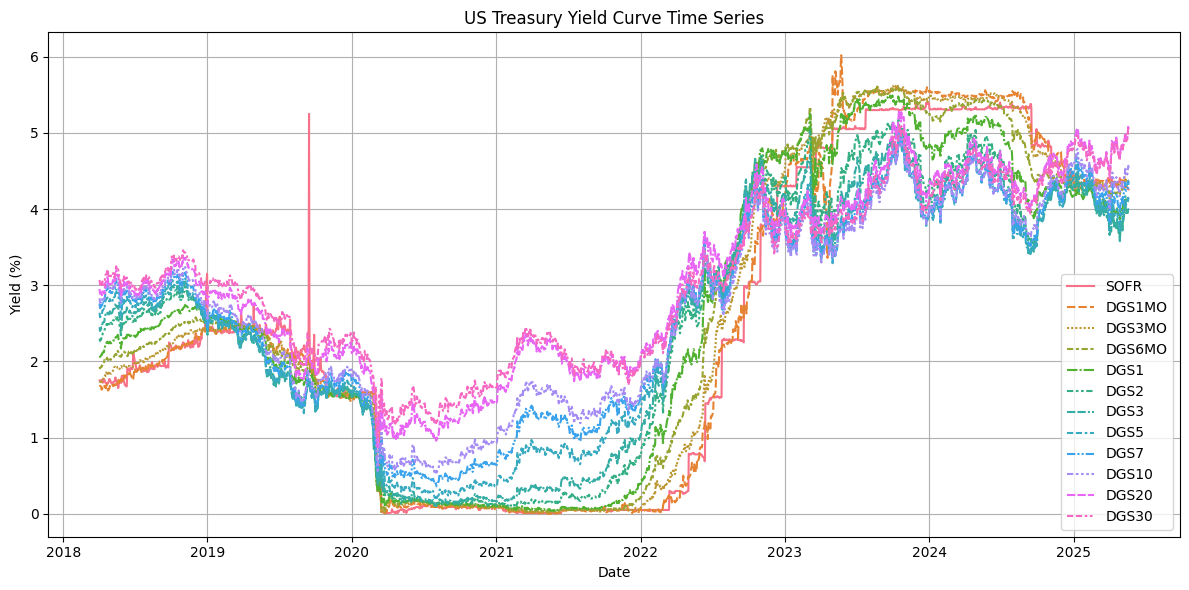

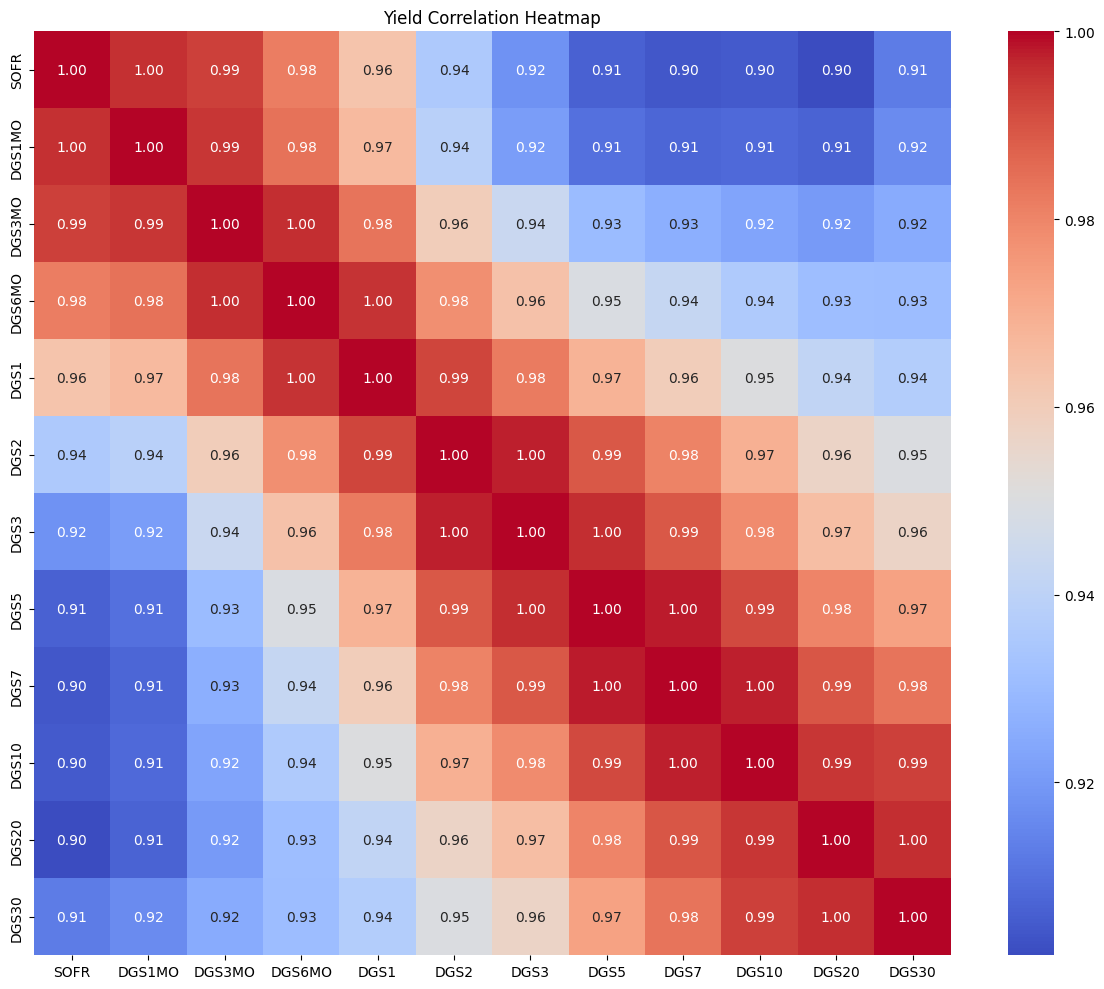

In [45]:
# === Visualize Yield Curve Over Time ===
plt.figure(figsize=(12, 6))
sns.lineplot(data=data)
plt.title("US Treasury Yield Curve Time Series")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Correlation Plot ===
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Yield Correlation Heatmap")
plt.tight_layout()
plt.show()

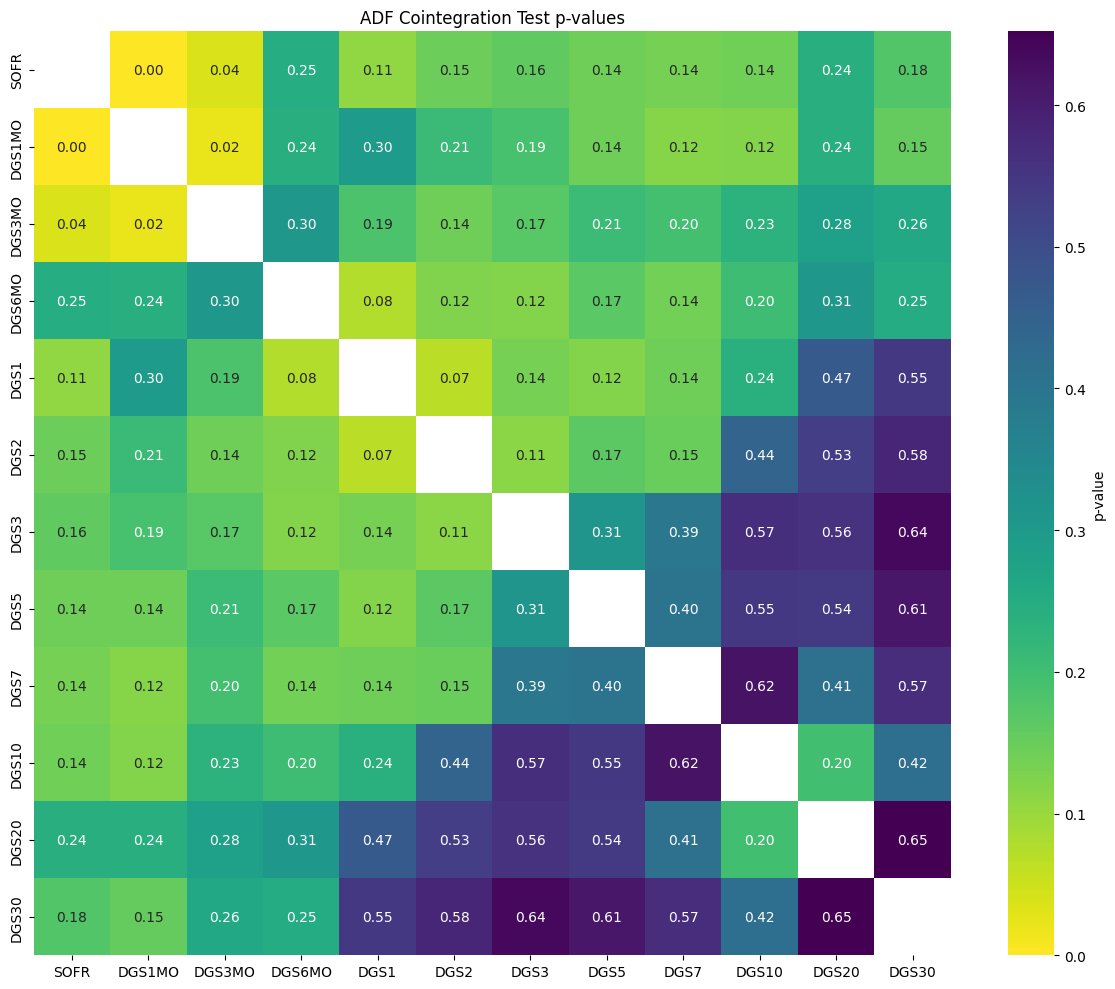

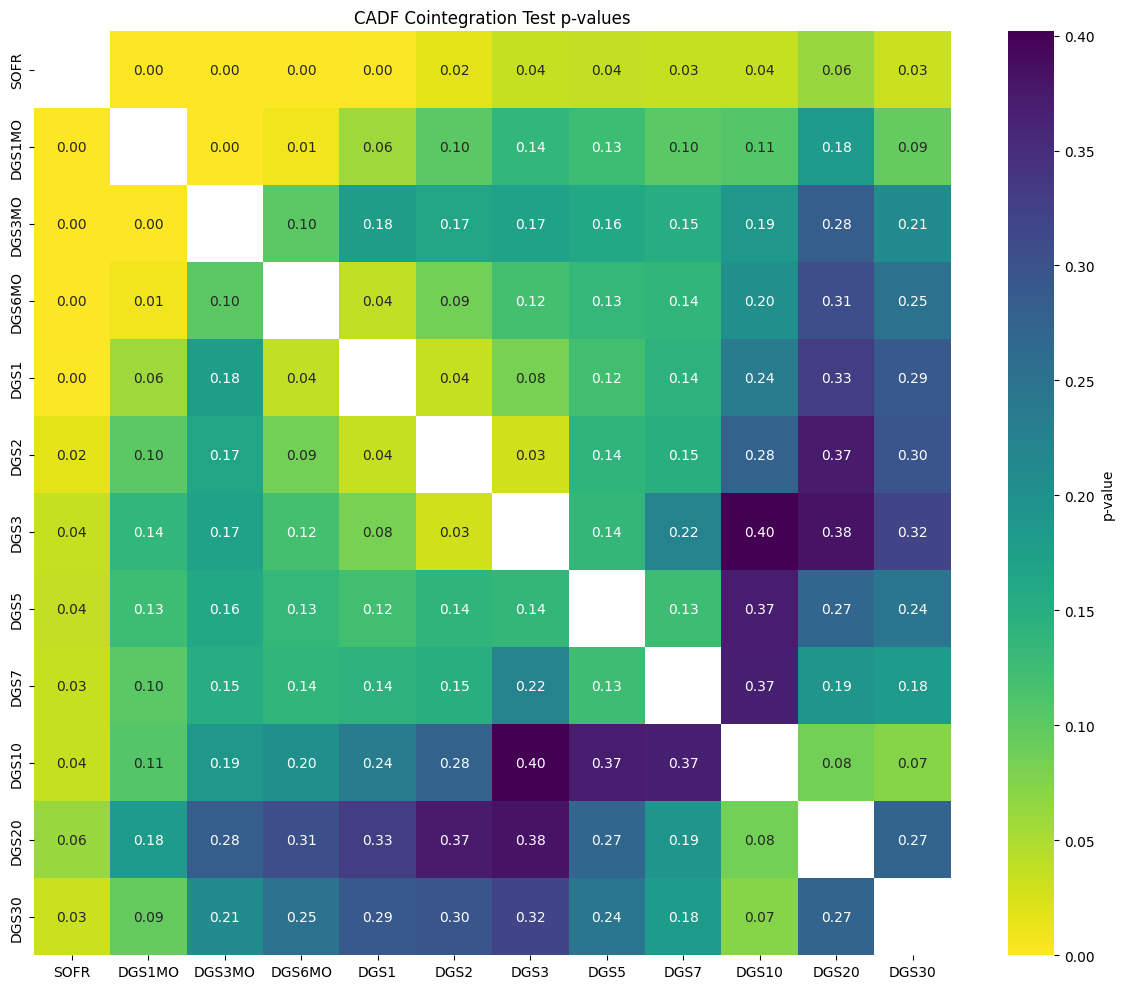

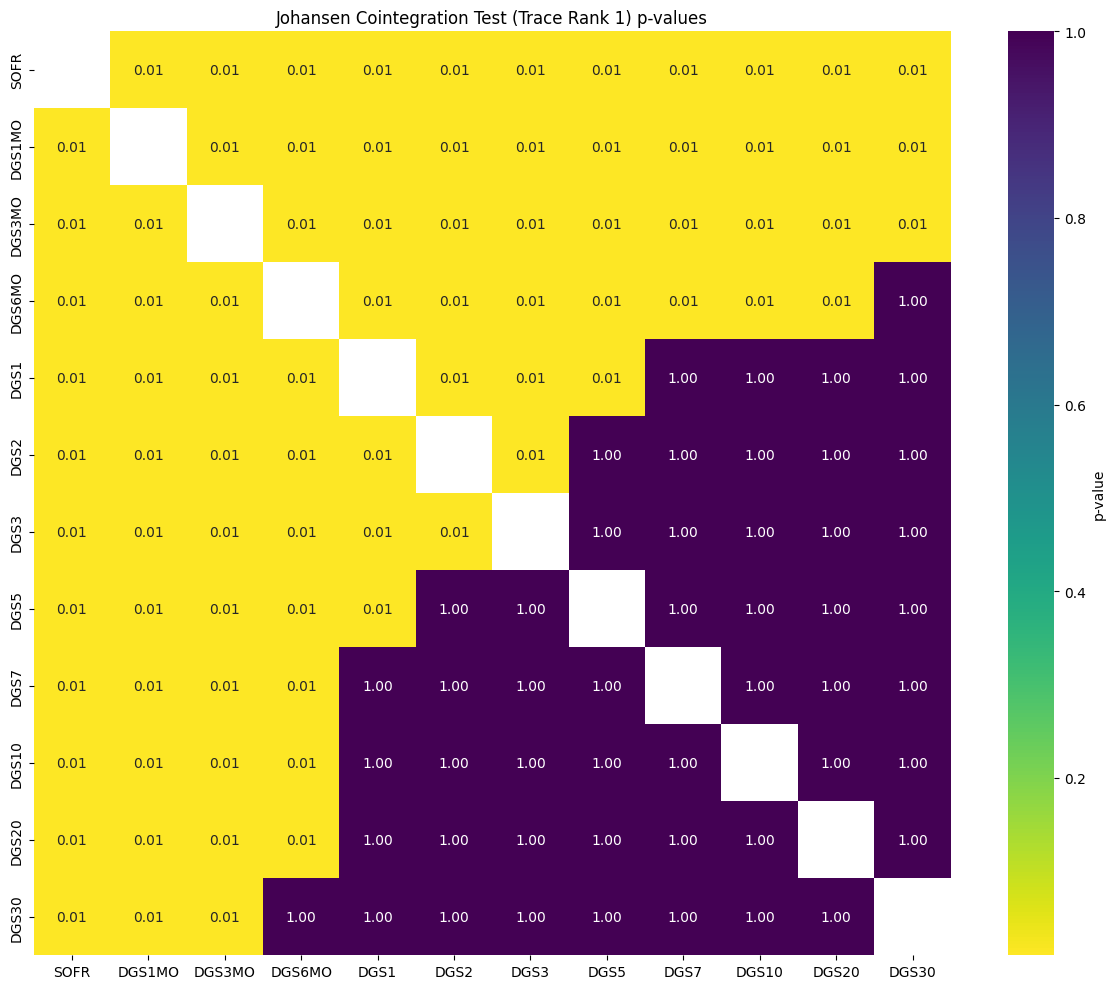

In [46]:
# === Initialize p-value matrices ===
adf_matrix = pd.DataFrame(index=columns, columns=columns)
cadf_matrix = pd.DataFrame(index=columns, columns=columns)
johansen_matrix = pd.DataFrame(index=columns, columns=columns)

# === Loop through all pairs ===
for col1, col2 in combinations(columns, 2):
    series1 = data[col1]
    series2 = data[col2]

    # --- ADF on residuals (Engle-Granger) ---
    model = OLS(series1, sm.add_constant(series2)).fit()
    residuals = model.resid
    adf_p = adfuller(residuals)[1]
    adf_matrix.loc[col1, col2] = adf_p
    adf_matrix.loc[col2, col1] = adf_p

    # --- CADF via statsmodels.tsa.stattools.adfuller on residuals ---
    cadf_p = adfuller(residuals, maxlag=1, regression='c')[1]
    cadf_matrix.loc[col1, col2] = cadf_p
    cadf_matrix.loc[col2, col1] = cadf_p

    # --- Johansen Test (rank 1 p-value) ---
    j_result = coint_johansen(data[[col1, col2]], det_order=0, k_ar_diff=1)
    trace_stat = j_result.lr1[0]
    trace_crit_95 = j_result.cvt[0, 1]
    p_value = 0.01 if trace_stat > trace_crit_95 else 1.0  # crude mapping
    johansen_matrix.loc[col1, col2] = p_value
    johansen_matrix.loc[col2, col1] = p_value

# === Plot p-value heatmaps ===
def plot_heatmap(matrix, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix.astype(float), annot=True, fmt=".2f", cmap="viridis_r", cbar_kws={"label": "p-value"})
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(adf_matrix, "ADF Cointegration Test p-values")
plot_heatmap(cadf_matrix, "CADF Cointegration Test p-values")
plot_heatmap(johansen_matrix, "Johansen Cointegration Test (Trace Rank 1) p-values")


In [33]:
# === Extract and print significant pairs (p < 0.05) ===
def extract_significant_pairs(matrix, test_name):
    sig_pairs = []
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            try:
                pval = float(matrix.iloc[i, j])
                if pval < 0.05:
                    sig_pairs.append((columns[i], columns[j], round(pval, 4)))
            except:
                continue
    return pd.DataFrame(sig_pairs, columns=['Rate 1', 'Rate 2', f'{test_name}_pval'])

# Get significant pairs
adf_sig = extract_significant_pairs(adf_matrix, "ADF")
cadf_sig = extract_significant_pairs(cadf_matrix, "CADF")
johansen_sig = extract_significant_pairs(johansen_matrix, "Johansen")

# Print results
print("\nSignificant ADF Cointegrated Pairs (p < 0.05):")
print(adf_sig.to_string(index=False))

print("\nSignificant CADF Cointegrated Pairs (p < 0.05):")
print(cadf_sig.to_string(index=False))

print("\nSignificant Johansen Cointegrated Pairs (p < 0.05):")
print(johansen_sig.to_string(index=False))



Significant ADF Cointegrated Pairs (p < 0.05):
Rate 1 Rate 2  ADF_pval
  SOFR DGS1MO    0.0000
  SOFR DGS3MO    0.0380
DGS1MO DGS3MO    0.0217

Significant CADF Cointegrated Pairs (p < 0.05):
Rate 1 Rate 2  CADF_pval
  SOFR DGS1MO     0.0000
  SOFR DGS3MO     0.0000
  SOFR DGS6MO     0.0000
  SOFR   DGS1     0.0021
  SOFR   DGS2     0.0178
  SOFR   DGS3     0.0358
  SOFR   DGS5     0.0374
  SOFR   DGS7     0.0348
  SOFR  DGS10     0.0356
  SOFR  DGS30     0.0323
DGS1MO DGS3MO     0.0000
DGS1MO DGS6MO     0.0084
DGS6MO   DGS1     0.0388
  DGS1   DGS2     0.0354
  DGS2   DGS3     0.0285

Significant Johansen Cointegrated Pairs (p < 0.05):
Rate 1 Rate 2  Johansen_pval
  SOFR DGS1MO           0.01
  SOFR DGS3MO           0.01
  SOFR DGS6MO           0.01
  SOFR   DGS1           0.01
  SOFR   DGS2           0.01
  SOFR   DGS3           0.01
  SOFR   DGS5           0.01
  SOFR   DGS7           0.01
  SOFR  DGS10           0.01
  SOFR  DGS20           0.01
  SOFR  DGS30           0.01
DGS1MO

ADF p-values:
SOFR: p = 0.9232
DGS3MO: p = 0.8775
DGS6MO: p = 0.8792
DGS2: p = 0.8945
DGS10: p = 0.9139
DGS30: p = 0.9383

Granger Causality Results (SOFR --> other rate):
SOFR -> DGS3MO: min p-value across lags = 0.0
SOFR -> DGS6MO: min p-value across lags = 0.0
SOFR -> DGS2: min p-value across lags = 0.0
SOFR -> DGS10: min p-value across lags = 0.0
SOFR -> DGS30: min p-value across lags = 0.0

VAR model summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Jun, 2025
Time:                     20:01:02
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -39.6903
Nobs:                     1855.00    HQIC:                  -40.0402
Log likelihood:           21719.9    FPE:                3.32737e-18
AIC:                     -40.2444    Det(Omega_mle):     3.01241e-18
--------------------------------------------------------------

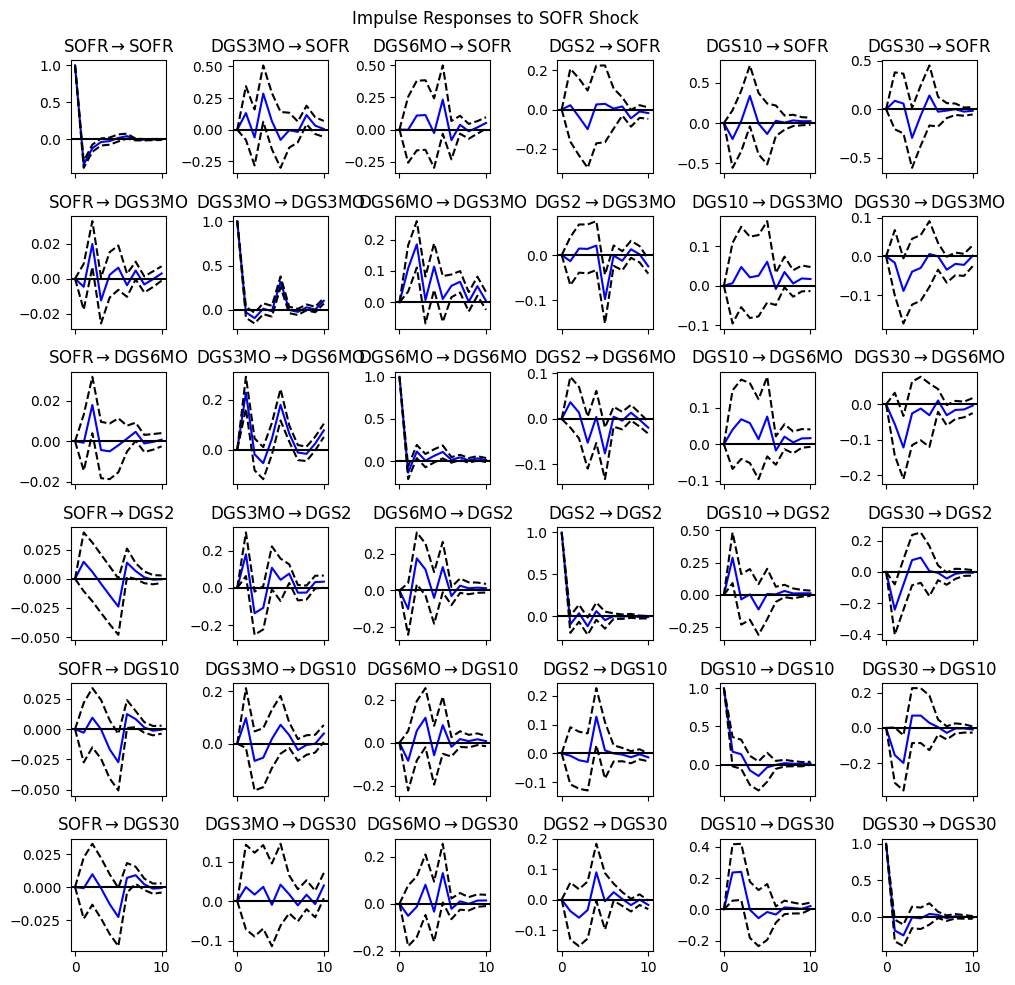

In [ ]:
# Select subset
selected_rates = ['SOFR','DGS3MO','DGS6MO','DGS2','DGS10','DGS30']
df = data[selected_rates].dropna()

# === 1. ADF test for stationarity ===
print("ADF p-values:")
for col in selected_rates:
    result = adfuller(df[col])
    print(f"{col}: p = {result[1]:.4f}")

# === 2. Granger Causality Test (does SOFR predict others?) ===
print("\nGranger Causality Results (SOFR --> other rate):")
for col in selected_rates[1:]:
    res = grangercausalitytests(df[['SOFR', col]], maxlag=5, verbose=False)
    pvals = [round(res[i+1][0]['ssr_chi2test'][1], 4) for i in range(5)]
    print(f"SOFR -> {col}: min p-value across lags = {min(pvals)}")

# === 3. VAR model ===
model = VAR(df.diff().dropna())  # First difference if not stationary
results = model.fit(maxlags=5, ic='aic')
print("\nVAR model summary:")
print(results.summary())

# === 4. Impulse Response Function ===
irf = results.irf(10)
irf.plot(orth=False)
plt.suptitle("Impulse Responses to SOFR Shock")
plt.tight_layout()
plt.show()
